In [2]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
plt.style.use('ggplot')
plt.rc('font', size=18)

In [4]:
connection_args = {
    'host':'3.86.206.29',
    'user':'ubuntu',
    'dbname':'mid',
    'port':5432
}
connection = pg.connect(**connection_args)

In [5]:
def is_prime(n):
    for i in range(2,n):
        if n%i==0:
            return False
    return True

def largestPrimeFactor(n):
    for i in range(n,1,-1):
        if n%i==0:
            if is_prime(i):
                return i

In [6]:
#query = "SELECT * FROM mida"
#mida = pd_sql.read_sql(query, connection)

In [7]:
mida = pd.read_stata('MID4/MIDA_4_3.dta')

In [8]:
mida.head()

,dispnum3,dispnum4,stday,stmon,styear,endday,endmon,endyear,outcome,settle,...,hiact,hostlev,recip,numa,numb,link1,link2,link3,ongo2010,version
0,2,-9,-9,7,1902,24,1,1903,6,1,...,7,3,0,1,1,0,0,0.0,0,4.3
1,3,-9,2,5,1913,25,10,1913,4,3,...,8,3,0,1,1,0,0,0.0,0,4.3
2,4,-9,15,5,1946,13,11,1946,5,3,...,16,4,1,1,1,0,0,0.0,0,4.3
3,7,-9,13,10,1951,26,1,1952,1,3,...,17,4,1,1,1,0,0,0.0,0,4.3
4,8,-9,-9,7,1856,14,3,1857,1,2,...,20,5,1,1,1,0,0,0.0,0,4.3


In [9]:
mida.columns

Index(['dispnum3', 'dispnum4', 'stday', 'stmon', 'styear', 'endday', 'endmon',
       'endyear', 'outcome', 'settle', 'fatality', 'fatalpre', 'maxdur',
       'mindur', 'hiact', 'hostlev', 'recip', 'numa', 'numb', 'link1', 'link2',
       'link3', 'ongo2010', 'version'],
      dtype='object')

In [10]:
mida.rename(columns={'dispnum3':'dispute_number_v3', 
                     'dispnum4':'dispute_number_v4', 
                     'stday':'start_day', 
                     'stmon':'start_month', 
                     'styear':'start_year', 
                     'endday':'end_day',
                     'endmon':'end_month',
                     'endyear':'end_year',
                     'fatality':'fatality_bucket',
                     'fatalpre':'fatalities_number',
                     'maxdur':'maximum_diration',
                     'mindur':'minimum_duration',
                     'hiact':'highest_hostile_action[hostility_level]',
                     'hostlev':'hostility_level',
                     'resip':'resiprocated_dispute',
                     'numa':'number_states_side_a',
                     'numb':'number_states_side_b',
                     'link1':'related_dispute_number_1',
                     'link2':'related_dispute_number_2',
                     'link3':'related_dispute_number_3',
                     'ongo2010':'ongoing_2010',
                     'version':'dataset_version'
                    }, inplace=True)

In [11]:
mida.replace(to_replace=-9,value=np.nan, inplace=True)

In [12]:
mida.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2315 entries, 0 to 2314
Data columns (total 24 columns):
dispute_number_v3                          2315 non-null int16
dispute_number_v4                          262 non-null float64
start_day                                  2048 non-null float64
start_month                                2315 non-null int8
start_year                                 2315 non-null int16
end_day                                    2065 non-null float64
end_month                                  2315 non-null int8
end_year                                   2315 non-null int16
outcome                                    2300 non-null float64
settle                                     2295 non-null float64
fatality_bucket                            2065 non-null float64
fatalities_number                          1684 non-null float64
maximum_diration                           2315 non-null int16
minimum_duration                           2315 non-null int16


In [13]:
mida.drop('dispute_number_v4', inplace=True, axis=1)

In [14]:
mida['start_day'].replace(to_replace=np.nan,value=15, inplace=True)

In [15]:
mida['end_day'].replace(to_replace=np.nan,value=15, inplace=True)

In [16]:
mida.drop(['fatalities_number'], inplace=True, axis=1)

In [17]:
mida.drop(['dataset_version'], inplace=True, axis=1)

In [18]:
mida['mid_start'] = pd.to_datetime(dict(year=mida.start_year, month=mida.start_month, day=mida.start_day)).astype(int)/10**9

In [19]:
mida['mid_end'] = pd.to_datetime(dict(year=mida.end_year, month=mida.end_month, day=mida.end_day)).astype(int)/10**9

In [20]:
mida['fatality_bucket'].replace(to_replace=np.nan, value=999, inplace=True)

In [21]:
mida['settle'].replace(to_replace=np.nan, value=4, inplace=True)

In [22]:
mida['related_dispute_number_3'].replace(to_replace=np.nan, value=0, inplace=True)

In [23]:
mida['outcome'].replace(to_replace=np.nan, value=8, inplace=True)

In [24]:
mida = mida[(mida['number_states_side_a'] == 1) & (mida['number_states_side_b'] == 1)]

In [25]:
mida['related_dispute_number_1'][mida['related_dispute_number_1']=='147W'] = np.nan

In [26]:
mida['related_dispute_number_2'][mida['related_dispute_number_2']=='166W'] = np.nan

In [27]:
mida.dropna(inplace=True)

In [28]:
mida.shape

(1956, 23)

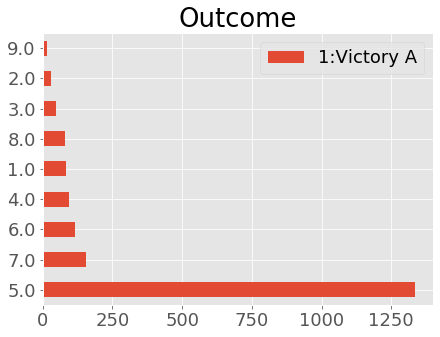

In [29]:
ax = mida['outcome'].value_counts().plot(kind='barh', figsize=(7,5), title='Outcome')
#ax.text(268,0,str(mida['outcome'].value_counts()[1]))
#ax.text(168,1,str(mida['outcome'].value_counts()[0]))
ax.legend(['1:Victory A', 
           '2:Victory B', 
           '3:Yield A', 
           '4:Yield B', 
           '5:Stalemate', 
           '6:Compromise', 
           '7:Released', 
           '8:Unclear', 
           '9:Joins ongoing war']);
#(line1, line2, line3), ('label1', 'label2', 'label3'))

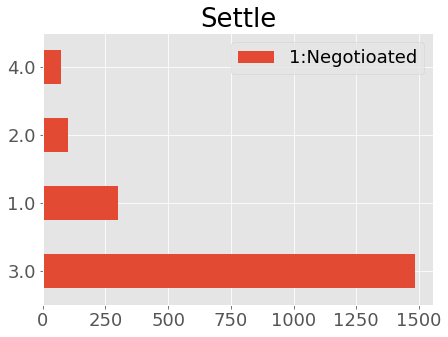

In [30]:
ax = mida['settle'].value_counts().plot(kind='barh', figsize=(7,5), title='Settle')
#ax.text(268,0,str(mida['outcome'].value_counts()[1]))
#ax.text(168,1,str(mida['outcome'].value_counts()[0]))
ax.legend(['1:Negotioated', '2:Imposed', '3:None', '4: Unclear']);
#(line1, line2, line3), ('label1', 'label2', 'label3'))

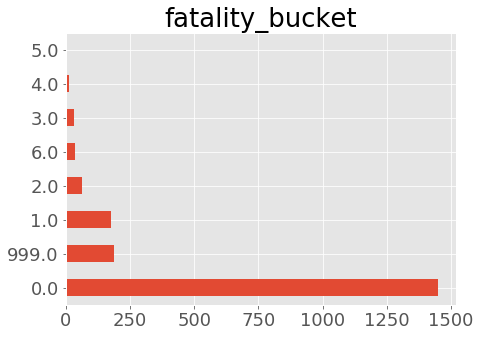

In [31]:
ax = mida['fatality_bucket'].value_counts().plot(kind='barh', figsize=(7,5), title='fatality_bucket')
#ax.text(268,0,str(mida['outcome'].value_counts()[1]))
#ax.text(168,1,str(mida['outcome'].value_counts()[0]))
#ax.legend(['1:Negotioated', '2:Imposed', '3:None', '4: Unclear']);
#(line1, line2, line3), ('label1', 'label2', 'label3'))

In [32]:
mida['hostility_level'].unique()

array([3, 4, 5, 2])

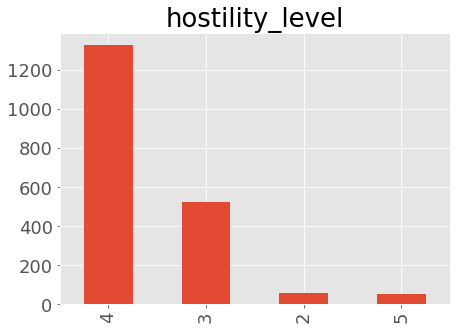

In [33]:
ax = mida['hostility_level'].value_counts().plot(kind='bar', figsize=(7,5), title='hostility_level')
#ax = mida['hostility_level'].value_counts().plot(kind='bar', figsize=(7,5), title='hostility_level')
#ax.(['1:no militarized action', '2:Threat to use force', '3:Display force', '4:Use of Force, 5: War']);
#ax.(['1:no militarized action', '2:Threat to use force', '3:Display force', '4:Use of Force, 5: War']);

In [34]:
mida.columns

Index(['dispute_number_v3', 'start_day', 'start_month', 'start_year',
       'end_day', 'end_month', 'end_year', 'outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration',
       'highest_hostile_action[hostility_level]', 'hostility_level', 'recip',
       'number_states_side_a', 'number_states_side_b',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end'],
      dtype='object')

In [35]:
sns.pairplot(mida[[ 'start_year',
        'end_year', 'outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration',
       'highest_hostile_action[hostility_level]', 'hostility_level', 'recip',
       'number_states_side_a', 'number_states_side_b',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end']])

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11505a680> (for post_execute):


KeyboardInterrupt: 

In [36]:
#dependent var into bin: use force in dispute
mida['hostility_level'].replace(to_replace=2,value=0, inplace=True) 
mida['hostility_level'].replace(to_replace=3,value=0, inplace=True) 
mida['hostility_level'].replace(to_replace=4,value=1, inplace=True) 
mida['hostility_level'].replace(to_replace=5,value=1, inplace=True) 

In [37]:
mida.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 2314
Data columns (total 23 columns):
dispute_number_v3                          1956 non-null int16
start_day                                  1956 non-null float64
start_month                                1956 non-null int8
start_year                                 1956 non-null int16
end_day                                    1956 non-null float64
end_month                                  1956 non-null int8
end_year                                   1956 non-null int16
outcome                                    1956 non-null float64
settle                                     1956 non-null float64
fatality_bucket                            1956 non-null float64
maximum_diration                           1956 non-null int16
minimum_duration                           1956 non-null int16
highest_hostile_action[hostility_level]    1956 non-null int8
hostility_level                            1956 non-null int8
recip

In [38]:
mida['related_dispute_number_1'] = mida['related_dispute_number_1'].astype(int)

In [39]:
mida['related_dispute_number_2'] = mida['related_dispute_number_2'].astype(int)

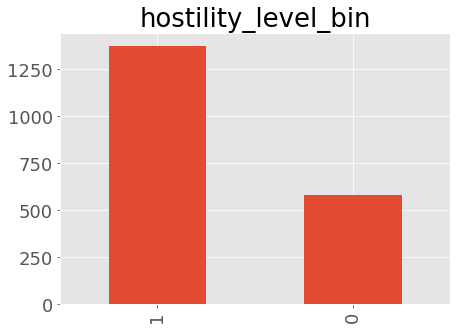

In [40]:
ax = mida['hostility_level'].value_counts().plot(kind='bar', figsize=(7,5), title='hostility_level_bin')

In [41]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
import warnings


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
def factorial(n):
    if n == 1:
        return n
    else:
        return n*factorial(n-1)

In [ ]:
#train-test split
train = mida[mida['start_year'] < 1990]
test = mida[mida['start_year'] > 1990]

In [320]:
test.shape

(527, 23)

In [321]:
train.shape

(1419, 23)

In [322]:
type(test)

pandas.core.frame.DataFrame

In [323]:
X_train = train[['outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration', 'recip',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end']]
X_test = test[['outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration', 'recip',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end']]
y_train = train['hostility_level']#.to_numpy().reshape(1, -1)
y_test = test['hostility_level']#

#removed 'highest_hostile_action[hostility_level]', 'highest_hostile_action[hostility_level]'

In [324]:
y_train.shape

(1419,)

In [325]:
#Logistic regression with weighting

In [326]:
logit=LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', max_iter=100) ##'bilinear' for 2 reasons, small dataset, handle L1 penalty

In [327]:
logit.fit(X_train, y_train)

/Users/elena/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [328]:
logit.score(X_test, y_test) #with arguments removed from the model: 0.5863377609108159

0.6110056925996205

In [329]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
naive_bayes.score(X_test, y_test)

0.5882352941176471

In [330]:
support_vector_classifier = SVC(class_weight='balanced')
support_vector_classifier.fit(X_train, y_train)
support_vector_classifier.score(X_test, y_test)

0.5882352941176471

In [331]:
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5673624288425048

In [332]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.571157495256167

In [333]:
import xgboost as xgb

In [337]:
boost=xgb.XGBClassifier(n_estimators=30000,
                        objective='binary:logistic', 
                        max_depth=7,
                        learning_rate=.1,
                        subsample=1,
                        min_chinld_weight=1,
                        colsample_bytree=.8)

In [342]:
eval_set = [(X_train, y_train)]

In [1]:
boost.fit(X_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=True)

In [344]:
#boost.fit(X_train, y_train)

In [345]:
boost.score(X_test, y_test)

0.5597722960151803

## Adding MIDB


In [367]:
sidea = pd.read_csv('MID4/midb_sidea.csv')

In [368]:
sideb = pd.read_csv('MID4/midb_sideb.csv')

In [369]:
sidea.columns

Index(['Unnamed: 0', 'dispute_number_v3_a', 'state_abbriviated_a',
       'country_code_a', 'start_day_a', 'start_month_a', 'start_year_a',
       'end_day_a', 'end_month_a', 'end_year_a', 'is_side_a_a',
       'is_revisionist_state_a', 'revision_type_1_a', 'fatality_bucket_a',
       'highest_hostile_action[hostility_level]_a', 'hostility_level_a',
       'dispute_originator_a', 'mid_start_a', 'mid_end_a'],
      dtype='object')

In [370]:
sideb = sideb[['dispute_number_v3_b', 'start_year_b', 'end_year_b', 
       'is_revisionist_state_b', 'revision_type_1_b', 'dispute_originator_b', 'mid_start_b', 'mid_end_b']]

In [371]:
sideb.rename(columns={'dispute_number_v3_b':'dispute_number_v3'}, inplace=True)

In [372]:
mida_b = mida.set_index('dispute_number_v3').join(sideb.set_index('dispute_number_v3'))

In [373]:
sidea = sidea[['dispute_number_v3_a', 'start_year_a', 'end_year_a', 
       'is_revisionist_state_a', 'revision_type_1_a', 'dispute_originator_a', 'mid_start_a', 'mid_end_a']]

In [374]:
sidea.rename(columns={'dispute_number_v3_a':'dispute_number_v3'}, inplace=True)

In [376]:
mida_ba = mida_b.join(sidea.set_index('dispute_number_v3'))

In [1]:
mida_ba.head()

NameError: name 'mida_ba' is not defined

In [399]:
#train-test split
train = mida_ba[mida_ba['start_year'] < 1990]
test = mida_ba[mida_ba['start_year'] > 1990]

In [400]:
test.shape

(527, 36)

In [401]:
train.shape

(1419, 36)

In [402]:
type(test)

pandas.core.frame.DataFrame

In [403]:
X_train = train[['outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration', 'recip',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end']]
X_test = test[['outcome', 'settle',
       'fatality_bucket', 'maximum_diration', 'minimum_duration', 'recip',
       'related_dispute_number_1', 'related_dispute_number_2',
       'related_dispute_number_3', 'ongoing_2010', 'mid_start', 'mid_end']]
y_train = train['hostility_level']#.to_numpy().reshape(1, -1)
y_test = test['hostility_level']#

#removed 'highest_hostile_action[hostility_level]', 'highest_hostile_action[hostility_level]'

In [404]:
y_train.shape

(1419,)

In [405]:
#Logistic regression with weighting

In [413]:
logit=LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', max_iter=100) ##'bilinear' for 2 reasons, small dataset, handle L1 penalty

In [414]:
logit.fit(X_train, y_train)

/Users/elena/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [415]:
logit.score(X_test, y_test) #with arguments removed from the model: 0.5863377609108159

0.6110056925996205

In [388]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
naive_bayes.score(X_test, y_test)

0.5882352941176471

In [389]:
support_vector_classifier = SVC(class_weight='balanced')
support_vector_classifier.fit(X_train, y_train)
support_vector_classifier.score(X_test, y_test)

0.5882352941176471

In [390]:
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5635673624288425

In [391]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5901328273244781

In [392]:
import xgboost as xgb

In [393]:
boost=xgb.XGBClassifier(n_estimators=30000,
                        objective='binary:logistic', 
                        max_depth=7,
                        learning_rate=.1,
                        subsample=1,
                        min_chinld_weight=1,
                        colsample_bytree=.8)

In [394]:
eval_set = [(X_train, y_train)]

In [395]:
boost.fit(X_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.19098
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.18041
[2]	validation_0-error:0.17830
[3]	validation_0-error:0.17125
[4]	validation_0-error:0.16913
[5]	validation_0-error:0.17266
[6]	validation_0-error:0.16843
[7]	validation_0-error:0.16984
[8]	validation_0-error:0.17054
[9]	validation_0-error:0.16913
[10]	validation_0-error:0.16772
[11]	validation_0-error:0.16350
[12]	validation_0-error:0.16420
[13]	validation_0-error:0.15645
[14]	validation_0-error:0.15504
[15]	validation_0-error:0.14870
[16]	validation_0-error:0.14729
[17]	validation_0-error:0.14658
[18]	validation_0-error:0.14729
[19]	validation_0-error:0.15152
[20]	validation_0-error:0.14940
[21]	validation_0-error:0.14799
[22]	validation_0-error:0.14799
[23]	validation_0-error:0.14870
[24]	validation_0-error:0.14517
[25]	validation_0-error:0.14517
[26]	validation_0-error:0.14306
[27]	validation_0-error:0.14165
[28]	validation_0-error:0.14165
[29]	validation_

[250]	validation_0-error:0.03101
[251]	validation_0-error:0.03171
[252]	validation_0-error:0.03101
[253]	validation_0-error:0.03030
[254]	validation_0-error:0.03030
[255]	validation_0-error:0.03030
[256]	validation_0-error:0.03030
[257]	validation_0-error:0.03030
[258]	validation_0-error:0.03030
[259]	validation_0-error:0.03030
[260]	validation_0-error:0.03030
[261]	validation_0-error:0.03030
[262]	validation_0-error:0.03030
[263]	validation_0-error:0.03030
[264]	validation_0-error:0.02889
[265]	validation_0-error:0.02889
[266]	validation_0-error:0.02889
[267]	validation_0-error:0.02889
[268]	validation_0-error:0.02960
[269]	validation_0-error:0.02960
[270]	validation_0-error:0.02960
[271]	validation_0-error:0.02960
[272]	validation_0-error:0.02960
[273]	validation_0-error:0.02960
[274]	validation_0-error:0.02960
[275]	validation_0-error:0.03030
[276]	validation_0-error:0.03030
[277]	validation_0-error:0.03030
[278]	validation_0-error:0.03030
[279]	validation_0-error:0.03030
[280]	vali

[499]	validation_0-error:0.01550
[500]	validation_0-error:0.01480
[501]	validation_0-error:0.01621
[502]	validation_0-error:0.01621
[503]	validation_0-error:0.01621
[504]	validation_0-error:0.01621
[505]	validation_0-error:0.01621
[506]	validation_0-error:0.01550
[507]	validation_0-error:0.01550
[508]	validation_0-error:0.01409
[509]	validation_0-error:0.01550
[510]	validation_0-error:0.01480
[511]	validation_0-error:0.01480
[512]	validation_0-error:0.01550
[513]	validation_0-error:0.01480
[514]	validation_0-error:0.01480
[515]	validation_0-error:0.01480
[516]	validation_0-error:0.01480
[517]	validation_0-error:0.01480
[518]	validation_0-error:0.01480
[519]	validation_0-error:0.01480
[520]	validation_0-error:0.01480
[521]	validation_0-error:0.01409
[522]	validation_0-error:0.01409
[523]	validation_0-error:0.01409
[524]	validation_0-error:0.01409
[525]	validation_0-error:0.01409
[526]	validation_0-error:0.01339
[527]	validation_0-error:0.01339
[528]	validation_0-error:0.01339
[529]	vali

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, min_chinld_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=30000, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [398]:
#boost.fit(X_train, y_train)

KeyboardInterrupt: 

In [397]:
boost.score(X_test, y_test)

0.5597722960151803